In [1]:
%reload_ext autoreload
%autoreload 2

import os 
print("当前工作目录：", os.getcwd())


当前工作目录： d:\REPO\fucking-kan\Efficient-KAN-in-Chinese


---

## 获取数据集

In [2]:
import torch
from torchvision import datasets, transforms

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 下载并加载CIFAR-100训练集
train_dataset = datasets.CIFAR100(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

# 下载并加载CIFAR-100测试集
test_dataset = datasets.CIFAR100(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

# 创建数据加载器
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False
)


c:\Users\29724\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


训练集样本形状: torch.Size([64, 3, 32, 32])
训练集标签形状: torch.Size([64])
测试集样本形状: torch.Size([64, 3, 32, 32])
测试集标签形状: torch.Size([64])


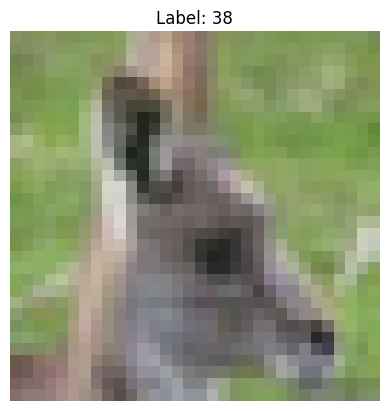

In [3]:

# 从训练集和测试集中各取一个batch进行抽样检查
train_batch = next(iter(train_loader))
test_batch = next(iter(test_loader))

# 打印样本信息
print("训练集样本形状:", train_batch[0].shape)
print("训练集标签形状:", train_batch[1].shape)
print("测试集样本形状:", test_batch[0].shape) 
print("测试集标签形状:", test_batch[1].shape)

# 可视化第一个训练样本
import matplotlib.pyplot as plt
plt.imshow(train_batch[0][0].permute(1, 2, 0) * 0.5 + 0.5)  # 反归一化
plt.title(f"Label: {train_batch[1][0]}")
plt.axis('off')
plt.show()

---

构建训练流程

In [4]:
from tqdm import tqdm

def train(model, train_loader, criterion, optimizer, num_epochs, device):
    # 初始化最佳准确率
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 使用tqdm包装每个batch
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # 更新tqdm进度条信息
            pbar.set_postfix({
                'Loss': running_loss/(pbar.n+1),
                'Acc': correct/total
            })
            
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # 打印训练结果
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        
    print('Training finished.')

def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    # 使用tqdm包装每个batch
    pbar = tqdm(test_loader, desc='Testing', leave=False)
    
    with torch.no_grad():
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            
            # 更新tqdm进度条信息
            pbar.set_postfix({
                'Loss': test_loss/(pbar.n+1),
                'Acc': test_correct/test_total
            })
            
    test_loss = test_loss / len(test_loader)
    test_acc = 100. * test_correct / test_total
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    return test_acc


---

## 创建模型



终端里运行
```
git clone https://github.com/lgy112112/vit-pytorch.git
cd vit-pytorch
pip install -e .
cd ..
```



如果无法安装，你可以将 vit-pytorch/setup.py 里的第三行改为:
`with open('README.md', 'r', encoding='utf-8') as f:`

如果下方出现 vit_pytorch 缺少，那么重启notebook再试



In [5]:
import torch
from vit_pytorch import ViT
from ikan import GroupKANLinear

v = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1,
    other_linear=GroupKANLinear
)

img = torch.randn(1, 3, 256, 256)

preds = v(img) # (1, 1000)

preds.shape

d:\REPO\fucking-kan\Efficient-KAN-in-Chinese\ikan\kat_rational\rational_triton.py:244: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
d:\REPO\fucking-kan\Efficient-KAN-in-Chinese\ikan\kat_rational\rational_triton.py:273: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx: torch.autograd.Function, grad_output: Tensor):
d:\REPO\fucking-kan\Efficient-KAN-in-Chinese\ikan\kat_rational\rational_triton2d.py:228: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
d:\REPO\fucking-kan\Efficient-KAN-in-Chinese\ikan\kat_rational\rational_triton2d.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` 

torch.Size([1, 1000])

---

开始训练


In [ ]:
import torch.nn as nn

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 将模型移动到设备
v = v.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 分类任务使用交叉熵损失
optimizer = torch.optim.Adam(v.parameters(), lr=0.001)

# 训练参数
num_epochs = 10

# 开始训练
train(v, train_loader, criterion, optimizer, num_epochs, device)

# 测试模型性能
test_acc = test(v, test_loader, criterion, device)
